## Tutorial of WEST 
The tutorial provides a brief instruction of how to implement the proposed method WEST (Weighted Ensemble method for Spatial Transcriptomics). The data used in the tutorial is the Visium data of a human brain cortex tissue. The detailed introduction of the data can be found in the paper. WEST is designed to ensemble the embeddings from multiple deep learning-based methods to achieve a better performance on the spatial domain identification. 

### 1. Import packages 
The packages imported here is the minimum requirement to run the WEST pipeline. The version of all packages is listed in the requirements.txt. Since the deep learning-based methods have much more complicated requirements to the environment, it is almost impossible to build an environment which is applicable for all of them. To simplify the tutorial, we provide the embeddings from two deep learning-based methods, SpaGCN and SpaceFlow, which is the only required data in the WEST pipelines. The pipeline can be easily extended to other deep learning-based methods.

In [1]:
# Import pacakges
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import umap
import datatable as dt
import scanpy as sc
import pickle

from sklearn.metrics.cluster import adjusted_rand_score

from WEST import WEST
import WEST_plt

2024-10-15 14:15:10.343606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 14:15:10.597251: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 14:15:12.268669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-15 14:15:12.268813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 2. Load data 
To simplify the tutorial, we save the original data in the pickle format. The data is in the anndata formation, which only contains the gene expression count matrix and the spatial coordinate of each spot.

In [2]:
# Read data from pickle
with open('../data/raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Load embedding & clustering result 
The embeddings of SpaGCN and SpaceFlow are loaded. They are the only required data for the WEST pipeline. To compare the spatial domain identification performance, we also load the spatial domain identification result of them, but they are not required for the WEST pipeline.

In [4]:
# Load embedding data
adata.obsm['SpaGCN'] = np.genfromtxt('../embedding/SpaGCN_embedding.csv', delimiter=',')
adata.obsm['SpaceFlow'] = np.genfromtxt('../embedding/SpaceFlow_embedding.csv', delimiter=',')

# Load clustering result
adata.obs['SpaGCN'] = np.genfromtxt('../embedding/SpaGCN_cluster.csv', delimiter=',', dtype=str)
adata.obs['SpaceFlow'] = np.genfromtxt('../embedding/SpaceFlow_cluster.csv', delimiter=',', dtype=str)

### 4. Run WEST 
This is the core step of the WEST pipeline. The description of the key parameters is listed as follow:  
-adata: an anndata.AnnData type object.  
-reps: the embeddings to integrate, e.g., ['SpaGCN', 'SpaceFlow'].  
-n_neighbors: number of neighbors, defalut: 20.  
-npcs: number of PCs to use, e.g., [20, 30]. If None, then use the original embedding, defalut: None.  
-seed: random seed, default: 1234.  
-distances: distance matrix. If None, then calculate the distance matrix, defalut: None.  

In [5]:
# Construct WEST object
west_obj = WEST(adata=adata, reps=['SpaGCN', 'SpaceFlow'], n_neighbors=10, npcs=None, seed=1234, distance=None)
# Compute the similarity matrix
west_obj.compute_west()
adata_west = west_obj.adata

Computing KNN distance matrices using default Scanpy implementation


/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Computing modality weights
time: 4.51 seconds
Selecting top K neighbors


### 5. Clustering  
Based on the calculated similarity matrix, we use Leiden to identify the spatial domain. To compare the performance of spatial domain detection, we calculate the adjusted rand index for WEST and the two ensembled two methods.

In [6]:
# Clustering using Leiden
sc.tl.leiden(adata_west, key_added="WEST", obsp="WEST", resolution=0.4)
# Compare clustering result
print("ARI for WEST: ", adjusted_rand_score(adata_west.obs["WEST"], adata_west.obs["true cluster"]))
print("ARI for SpaGCN: ", adjusted_rand_score(adata_west.obs["SpaGCN"], adata_west.obs["true cluster"]))
print("ARI for SpaceFlow: ", adjusted_rand_score(adata_west.obs["SpaceFlow"], adata_west.obs["true cluster"]))

ARI:  0.5322530452942107
['2', '1', '5', '0', '4', '3']
Categories (6, object): ['0', '1', '2', '3', '4', '5']


### 6. Generate new embedding 
This step is to generate the embedding based on the calculated similarity matrix.

In [13]:
adata_west.obsm['WEST'] = west_obj.get_embedding(dim=50)
adata_west.obsm['WEST']

array([[ 7.39645905e-05,  1.37060232e-04,  5.39569407e-05, ...,
        -1.33955929e-04,  4.06737586e-05,  7.93043413e-05],
       [ 9.52878772e-05, -1.06616642e-04, -8.72768497e-05, ...,
         1.61737489e-04, -5.13994817e-05,  4.54648178e-05],
       [-1.69390200e-04,  3.12066942e-05,  4.25486305e-05, ...,
        -2.05785442e-05, -3.73216551e-04, -6.71347602e-05],
       ...,
       [ 1.51874353e-04, -1.76881941e-04,  1.64157788e-04, ...,
         9.79680955e-08,  5.46685810e-05,  2.23860356e-04],
       [-5.73555281e-05, -1.62194175e-04,  1.84448736e-04, ...,
        -1.07006443e-05, -2.81614393e-04, -9.26324289e-05],
       [-1.59319263e-04,  9.45411763e-05,  1.28293279e-04, ...,
         3.27912866e-05,  2.46751497e-04,  1.41119066e-04]])

### 7. Visualization
We provide two ways to visualize the result. One is to use the scatter plot to visualize the spatial domain detected by each method. It can be used to evaluate how consistent the detected domain is with the manually annotated spatial domain. The other is to use the UMAP plot to see the pattern on the embedding space. The color represents the manually annotated spatial domain. It can be used to find some hidden structures of the tissue and provide more insights.

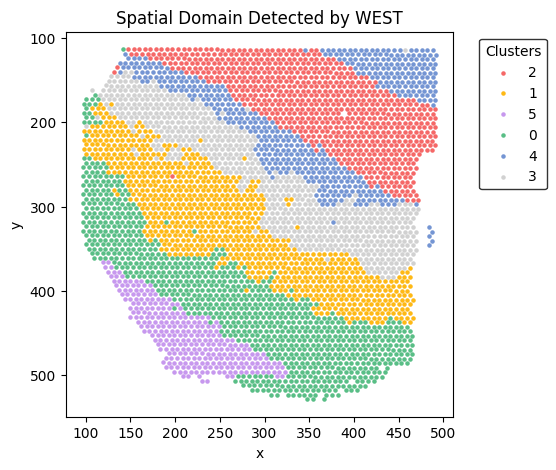

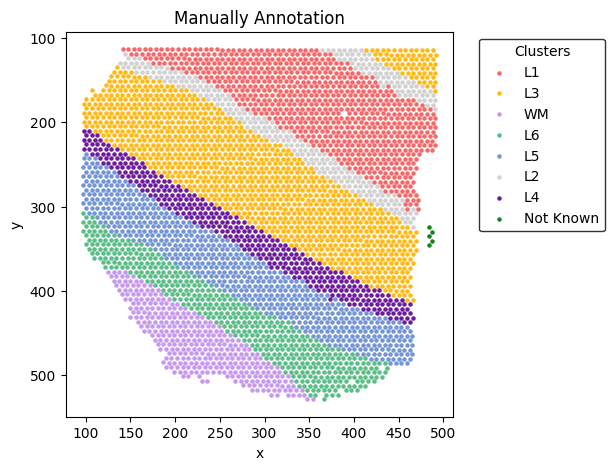

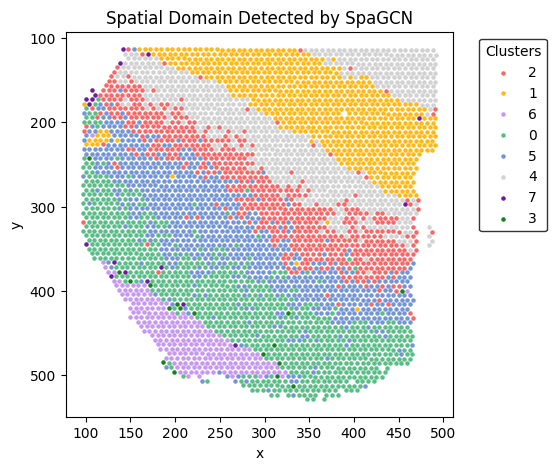

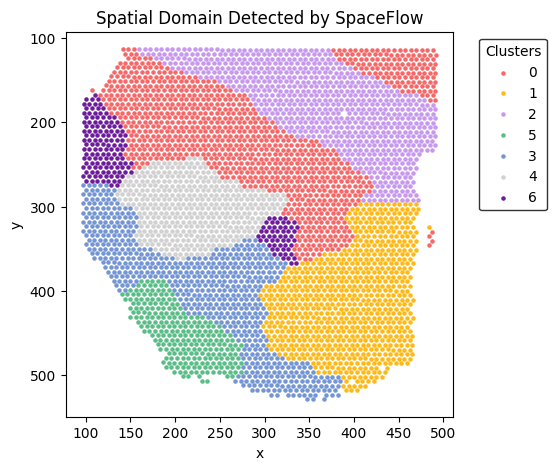

In [10]:
# Visualization using scatter plot
WEST_plt.WEST_scatter(adata=adata_west, reps='WEST', title='Spatial Domain Detected by WEST', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)
WEST_plt.WEST_scatter(adata=adata_west, reps='true cluster', title='Manually Annotation', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)
WEST_plt.WEST_scatter(adata=adata_west, reps='SpaGCN', title='Spatial Domain Detected by SpaGCN', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)
WEST_plt.WEST_scatter(adata=adata_west, reps='SpaceFlow', title='Spatial Domain Detected by SpaceFlow', cmap=None,
                      s=5, width=5, height=5, switch_coordinate=True, invert_x=False, invert_y=True, save_path=None)

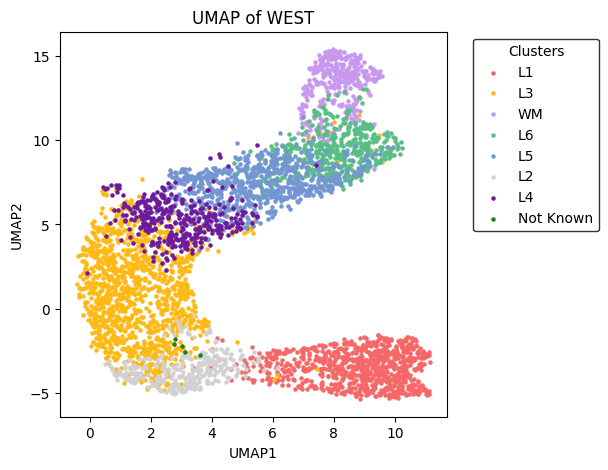

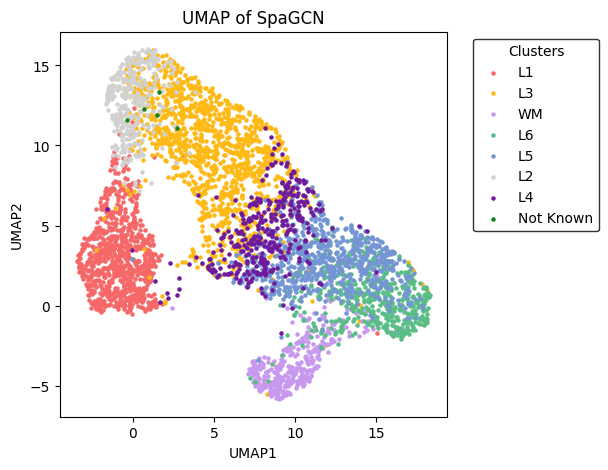

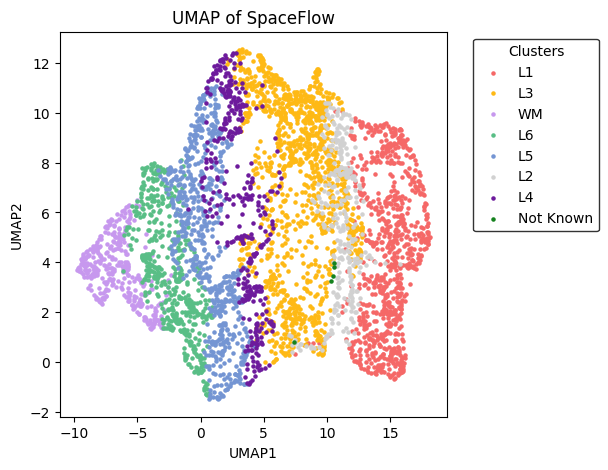

In [11]:
# Visualization using UMAP
WEST_plt.WEST_umap(adata=adata_west, reps='WEST', title='UMAP of WEST', cmap=None, s=5, width=5, height=5, save_path=None)
WEST_plt.WEST_umap(adata=adata_west, reps='SpaGCN', title='UMAP of SpaGCN', cmap=None, s=5, width=5, height=5, save_path=None)
WEST_plt.WEST_umap(adata=adata_west, reps='SpaceFlow', title='UMAP of SpaceFlow', cmap=None, s=5, width=5, height=5, save_path=None)